# Hypergraph-to-CombinatorialComplex Universal Strict Lifting Tutorial

***
This notebook shows how to import a dataset, with the desired lifting, and how to run a neural network using the loaded data.

The notebook is divided into sections:

- [Loading the dataset](#loading-the-dataset) loads the config files for the data and the desired tranformation, createsa a dataset object and visualizes it.
- [Loading and applying the lifting](#loading-and-applying-the-lifting) defines a simple neural network to test that the lifting creates the expected incidence matrices.
- [Create and run a simplicial nn model](#create-and-run-a-simplicial-nn-model) simply runs a forward pass of the model to check that everything is working as expected.

***
***

Note that for simplicity the notebook is setup to use a simple graph. However, there is a set of available datasets that you can play with.

To switch to one of the available datasets, simply change the *dataset_name* variable in [Dataset config](#dataset-config) to one of the following names:

* cocitation_cora
* cocitation_citeseer
* cocitation_pubmed
* MUTAG
* NCI1
* NCI109
* PROTEINS_TU
* AQSOL
* ZINC
***

### Imports and utilities

In [1]:
# With this cell any imported module is reloaded before each cell execution
%load_ext autoreload
%autoreload 2
from modules.data.load.loaders import HypergraphLoader
from modules.data.preprocess.preprocessor import PreProcessor
from modules.utils.utils import (
    describe_data,
    load_dataset_config,
    load_model_config,
    load_transform_config,
    plot_manual_hypergraph,
)

%reload_ext autoreload

## Loading the Dataset

Here we just need to spicify the name of the available dataset that we want to load. First, the dataset config is read from the corresponding yaml file (located at `/configs/datasets/` directory), and then the data is loaded via the implemented `Loaders`.


In [2]:
dataset_name = "manual_hypergraph_dataset"
dataset_config = load_dataset_config(dataset_name)
loader = HypergraphLoader(dataset_config)


Dataset configuration for manual_hypergraph_dataset:

{'data_domain': 'hypergraph',
 'data_type': 'toy_dataset',
 'data_name': 'manual',
 'data_dir': 'datasets/hypergraph/toy_dataset',
 'num_features': 1,
 'num_classes': 2,
 'task': 'classification',
 'loss_type': 'cross_entropy',
 'monitor_metric': 'accuracy',
 'task_level': 'node'}


We can then access to the data through the `load()`method:


Dataset only contains 1 sample:


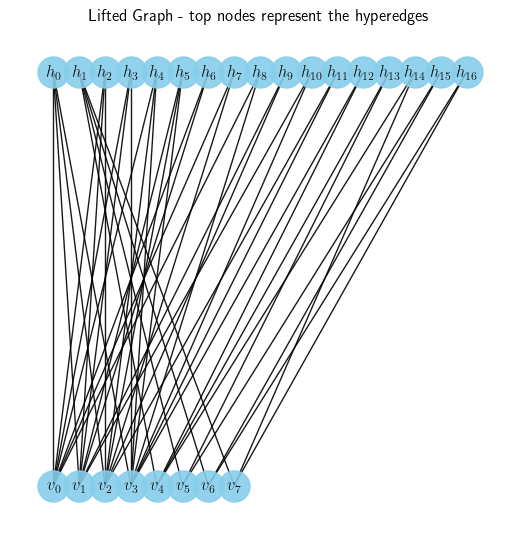

 - Graph with 8 vertices and 42 edges.
 - Features dimensions: [1, 0]
 - There are 0 isolated nodes.



In [3]:
dataset = loader.load()
describe_data(dataset)

We provide an alternative visualization function `plot_manual_hypergraph` where hyperedges are represented as polygonal regions containing the vertices in the hyperedge:

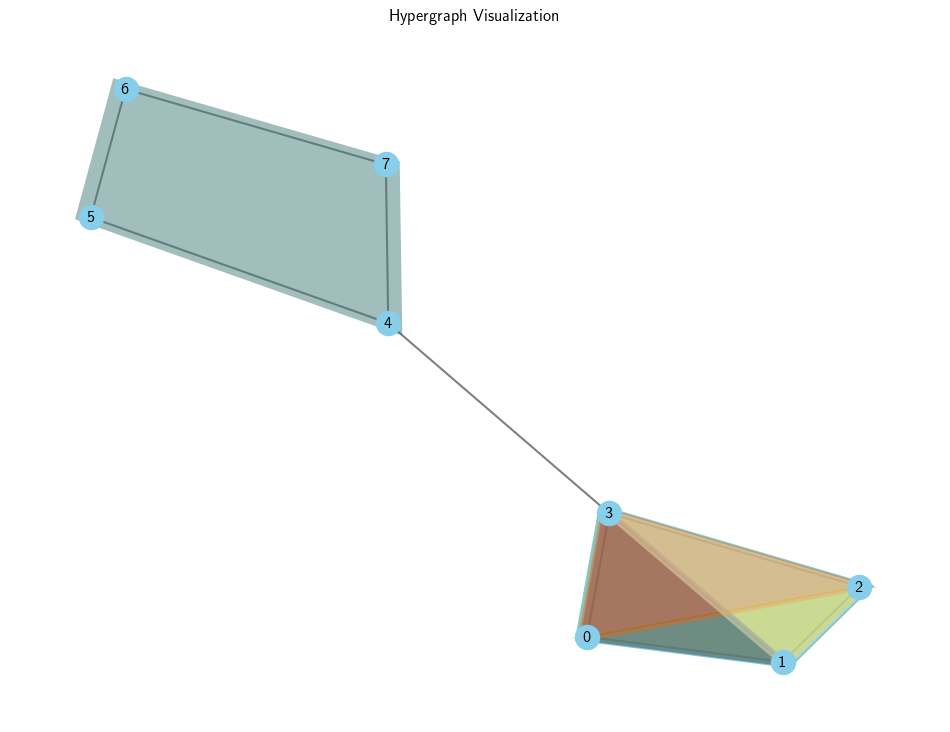

In [4]:
plot_manual_hypergraph(dataset)

## Loading and Applying the Lifting

In this section we will instantiate the lifting we want to apply to the data.

The Universal Strict Lifting takes a hypergraph and lifts it to a combinatorial complex. It **does not introduce extra cells**: every cell in the lifted CC corresponds to a hyperedge in the original hypergraph. Combinatorial complexes carry more information than hypergraphs, in the form of a rank function taking nonnegative values on each cell, satisfying a topological requirement (see [[1]](https://arxiv.org/pdf/2206.00606)). The Universal Strict Lifting provides such a rank function in a deterministic manner.

### Idea behind the lifting
The Universal Strict Lifting, applied to the `manual_hypergraph`, assigns:

$$ \mathrm{rk}(\{0,1,2,3\}) = 3 $$
$$ \mathrm{rk}(\{4,5,6,7\}) = 2 $$

Essentially, the first cell is interpreted as a solid tetrahedron, whereas the second one is interpreted as a square. This leverages a feature of combinatorial complexes which is already present in cell complexes: that the dimension of a cell is **not** necessarily equal to the number of vertices it contains.

The key idea of the algorithm is as follows: although hyperedges $\{0,1,2,3\}$ and $\{4,5,6,7\}$ both have 4 vertices, the former has sub-hyperedges such as $\{0,1,2\}$ (which will be assigned rank $2$), so the rank of $\{0,1,2,3\}$ is $$1 +\mathrm{max}_c\{\mathrm{rk}(c)\} = 3 $$
where $c$ ranges over the subcells of $\{0,1,2,3\}$.

The computational complexity of the algorithm is $O(n^2m)$ where $n$ is the number of hyperedges in the hypergraph and $m$ is the maximum hyperedge size.

***
[[1]](https://arxiv.org/pdf/2206.00606) Hajij, M., Zamzmi, G., Papamarkou, T., Miolane, N., Guzmán-Sáenz, A., Natesan Ramamurthy, K., Birdal, T., Dey, T., Mukherjee, S., Samaga, S., Livesay, N., Walters, R., Rosen, P., & Schaub, M. (2023). Topological deep learning: Going beyond graph data.
***

In [5]:
# Define transformation type and id
transform_type = "liftings"
# If the transform is a topological lifting, it should include both the type of the lifting and the identifier
transform_id = "hypergraph2combinatorial/universal_strict_lifting"

# Read yaml file
transform_config = {
    "lifting": load_transform_config(transform_type, transform_id)
    # other transforms (e.g. data manipulations, feature liftings) can be added here
}


Transform configuration for hypergraph2combinatorial/universal_strict_lifting:

{'transform_type': 'lifting', 'transform_name': 'UniversalStrictLifting'}


We then apply the transform via our `PreProcesor`:

In [7]:
lifted_dataset = PreProcessor(dataset, transform_config, loader.data_dir)
describe_data(lifted_dataset)
lifted_dataset[0]

Processing...
Done!


{0, 1}
{0, 2}
{0, 3}
{1, 2}
{1, 3}
{2, 3}
{3, 4}
{4, 5}
{4, 7}
{5, 6}
{6, 7}
{0, 1, 2}
{0, 1, 3}
{0, 2, 3}
{1, 2, 3}
{0, 1, 2, 3}
{4, 5, 6, 7}

Dataset only contains 1 sample:


NetworkXError: Edge tuple [] must be a 2-tuple or 3-tuple.


Dataset only contains 1 sample:


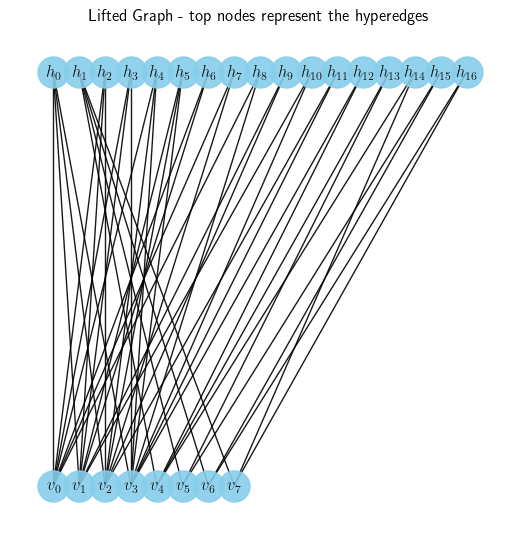

 - Graph with 8 vertices and 42 edges.
 - Features dimensions: [1, 0]
 - There are 0 isolated nodes.



In [19]:
new_dataset = lifted_dataset
describe_data(new_dataset)

In [9]:
from modules.models.combinatorial.hmc import HMCModel

model_type = "combinatorial"
model_id = "hmc"
model_config = load_model_config(model_type, model_id)

model = HMCModel(model_config, dataset_config)


Model configuration for combinatorial HMC:

{'in_channels': None,
 'hidden_channels': 32,
 'out_channels': None,
 'n_layers': 2}


NameError: name 'SANModel' is not defined

In [21]:
new_dataset[0]

Data(x=[8, 1], edge_index=[2, 42], y=[8], incidence_hyperedges=[8, 17], neighborhood_0_to_0=[8, 8], neighborhood_0_to_1=[8, 8], neighborhood_0_to_2=[8, 8], neighborhood_0_to_3=[8, 8], shape=[4], neighborhood_1_to_1=[11, 11], neighborhood_1_to_2=[11, 11], neighborhood_1_to_3=[11, 11], neighborhood_2_to_2=[5, 5], neighborhood_2_to_3=[5, 5], neighborhood_3_to_3=[1, 1], x_1=[0], x_2=[0], x_3=[0])